# Edit: Thanks for the gold kind stranger

### Class

Texas A&M University CSCE 489 with Dr. Caverlee

### Team Members

1. Jeremy Moorman
2. John Ansted
3. Charlie Zhang

 # Overview and Motivation 

### Overview

In our project, we analyzed reddit comments from January to May in 2015 to create a classifier that analyzes comments and determines whether or not they will be gilded.

### Motivation

Our motivation was to be able to predict whether a comment would be gilded when submitted to a specific subreddit.  By being able to come up with a probability percentage, we could could create a new sorting algorithm that sorted the comments of a post by how likely they were to be gilded rather than the original scoring sorting.

# Related Work

As far as we know, there has been no exploration into gilded comment analysis.  Reddit is constantly shifting its sorting algorithm based on the comment score, but not gilded status.

# Initial Questions

We originally wanted to analyze what features (such as word count or time of posting) of make a comment gild worthy.  We expected these features to differ between subreddits and we wanted to see how.  

# Exploratory Data Analysis

### Gold Distribution Among Subreddits

We found out that 50% of the reddit gold income is from 10 subreddits with AskReddit contributing to half of that (25% of the total income).  Because of this, we decided to limit our scope to these 10 subreddits.

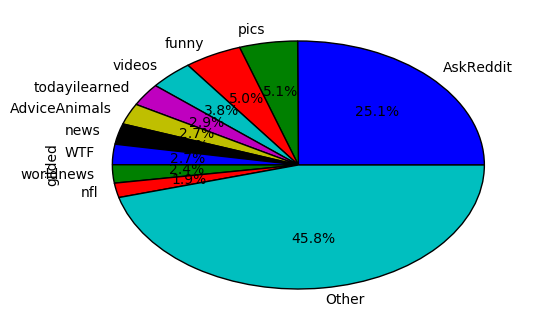

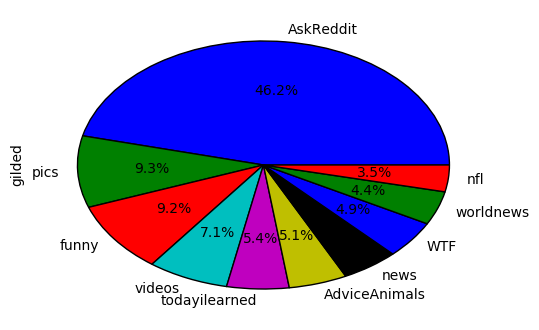

In [43]:
import matplotlib.pyplot as plt
%matplotlib inline

from scripts import Munger as mg
import datetime
import pandas as pd


filename = './Other Notebooks/Start Data/2015/RC_2015-01_gilded.csv'

data = pd.read_csv(filename)
temp = pd.read_csv('./Other Notebooks/Start Data/2015/RC_2015-02_gilded.csv')
data = data.append(temp, ignore_index=True)
temp = pd.read_csv('./Other Notebooks/Start Data/2015/RC_2015-03_gilded.csv')
data = data.append(temp, ignore_index=True)
temp = pd.read_csv('./Other Notebooks/Start Data/2015/RC_2015-04_gilded.csv')
data = data.append(temp, ignore_index=True)
temp = pd.read_csv('./Other Notebooks/Start Data/2015/RC_2015-05_gilded.csv')
data = data.append(temp, ignore_index=True)

topsum = data.groupby('subreddit')[['gilded']].count().sort_values('gilded', ascending=False).head(10).sum()
remaindersum = data.groupby('subreddit')[['gilded']].count().sort_values('gilded', ascending=True).head(-10).sum()

top = data.groupby('subreddit')[['gilded']].count().sort_values('gilded', ascending=False).head(10)
top.append(pd.DataFrame([(remaindersum-topsum)], columns=['gilded'], index=['Other'])).plot(kind='pie', y='gilded',autopct='%1.1f%%', legend=False)
top.plot(kind='pie', y='gilded',autopct='%1.1f%%', legend=False)


### Does Time of Day Matter?

We decided to check if the time of posting was relevant.  Each comment from our dataset came with a unix epoch timestamp.  We transposed the timestamp into a human readable date and time, dropped the date, and them classified the time as one of the following:

1. Morning: 5:00am - 11:59am (~7 hours)
2. Afternoon: 12:00pm - 4:59pm (~5 hours)
3. Evening: 5:00pm - 8:59pm (~4 hours)
4. Night: 9:00pm - 4:59am (~8 hours)

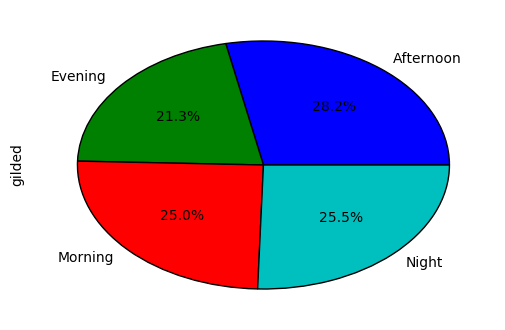

In [12]:
data = pd.read_csv('./Subreddits/mytrain/addedAdviceAnimals_train.csv')


from sklearn.linear_model import LinearRegression
lm_in_sklearn = LinearRegression()

data.groupby('Time of Day')[['gilded']].count().plot(kind='pie',y='gilded', autopct='%1.1f%%', legend=False)

Something interesting we noted was that the Morning and Afternoon classifications had the highest amount of gilded comments even though the Afternoon classification was one of the shortest time periods.  Something to keep in mind though is that these timestamps are in UTC and do not accurately represent the time period the user percieved they were in when they posted the comment.

### Comment Makeup

We decided to break down each comment and find out what features of the text actually mattered.  We started simple and created a couple functions that utilized regular expressions to determine if the comment:

1. Contained Emojis
2. Contained Markdown
3. Contained a "tldr"
4. Word Count

<img src="./Photos/WTFSimple.png" alt="SimpleFeatureAnalysis" style="width:600px;height:600px;">

In this particular set of training and test data, our features did not have the impact we had hoped.  It seemed that the only feature that mattered was the word count, and that was not enough to build a high scoring classifier on.  

### Sentiment and Tone Analysis

We then deciced to search for some other options for analyzing the comment text and decided to find libraries that supported:

1. Sentiment Analysis
2. Tone Analysis
3. Grammatical Error Checking

<img src="./Photos/WatsonFA.png" alt="Inclusion of Watson Tone Analysis" style="width:500px;height:700px;">

After offloading some of our munging to IBM Watson's Tone Analyzer, we were able to build a much more accurate and representative model.  We still were not satisfied with our results though.  With Watson, we were limited to how many comments we could analyze for our test and training data and we were only able to get a classifier score between 0.64 and 0.71.

### What Were We Missing?

While we were making progress with our classifier, it still was not scoring as high as we had hoped.  After some discussion, we believe one of the key factors is the context of the comment.  A comment that gets gilded in one thread may be completely disregarded in another because it is not contextually related.  Therefore, we decided to focus only on top-level comments where the context is not as important since it is an initial response instead of a continued conversation. 

Secondly, we were not including the score of the comment in our analysis for the sake of our final application.  We wanted to build a classifier that took a fresh comment without a score.  However, score was the most important feature (as shown below) and because of this, we attempted to build a second classifier to predict the expected score of a fresh comment.

### Inclusion of Score

We were able to build an accurate classifier for the predicted score of a comment:

<img src="./Photos/ScoreFeatures.png" alt="Score Features" style="width:450px;height:600px;">

But by including our predicted score in our gilded classifier, we then had the inaccuracies of both classifiers being multiplied together creating an overall inaccurate classifier.  Because of this, we decided to forgo the score classifier and just use the comment's actual score.

# Final Analysis

Based on our analysis, each subreddit has some shared important features in determing whether a comment will be gilded such as:

1. Score
2. Word Count

Some subreddits are more privy to gilding comments that contains links to pictures or other media:

1. pics
2. videos
3. funny

While others are completely reliant on the readable text content like grammatical errors and the cluster of the comment TFDIDF vector:

1. AskReddit
2. WTF
3. news
4. worldnews
5. nfl

This makes sense for these subreddits where the comments are mostly long entries of texts rather than funny pictures or other media.

We were able to create classifiers for each of our 10 subreddits (listed below) with accuracy ranging from 82% to 90%.  

# Presentation

**r/AdviceAnimals**
<img src="./Photos/AskAnimals.png" alt="AskAnimals" style="width:600px;height:600px;">
[r/AdviceAnimals Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/AdviceAnimals%20Feature%20Importance%20Analysis.ipynb)

**r/AskReddit**
<img src="./Photos/AskReddit.png" alt="AskReddit" style="width:600px;height:600px;">
[r/AskReddit Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/AskReddit%20Feature%20Importance%20Analysis.ipynb)

**r/funny**
<img src="./Photos/Funny.png" alt="Funny" style="width:600px;height:600px;">
[r/funny Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/funny%20Feature%20Importance%20Analysis.ipynb)

**r/news**
<img src="./Photos/news.png" alt="News" style="width:600px;height:600px;">
[r/news Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/news%20Feature%20Importance%20Analysis.ipynb)

**r/nfl**
<img src="./Photos/NFL.png" alt="NFL" style="width:600px;height:600px;">
[r/nfl Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/nfl%20Feature%20Importance%20Analysis.ipynb)

**r/pics**
<img src="./Photos/Pics.png" alt="Pics" style="width:600px;height:600px;">
[r/pics Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/pics%20Feature%20Importance%20Analysis.ipynb)

**r/todayilearned**
<img src="./Photos/TIL.png" alt="TIL" style="width:600px;height:600px;">
[r/todayilearned Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/todayilearned%20Feature%20Importance%20Analysis.ipynb)

**r/videos**
<img src="./Photos/Video.png" alt="Vidoes" style="width:600px;height:600px;">
[r/videos Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/videos%20Feature%20Importance%20Analysis.ipynb)

**r/worldnews**
<img src="./Photos/Worldnews.png" alt="worldnews" style="width:600px;height:600px;">
[r/worldnews Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/worldnews%20Feature%20Importance%20Analysis.ipynb)

**r/WTF**
<img src="./Photos/WTF.png" alt="WTF" style="width:600px;height:600px;">
[r/WTF Notebook](https://github.com/jsmoorman/csce489_gold/blob/master/Subreddits/WTF%20Feature%20Importance%20Analysis.ipynb)

### Final Project

For our final project we decided to build a django webserver that takes in a comment and returns a boolean value of whether or not our classifier believes it will become gilded.  Our original idea was to take a completely new comment and attempt to classify it without any score associated with it, but the task of attempting to predict a comment's score to then use in our classifier was not only inaccurate in the end, but a completely different problem that would require much more time to tackle.  In the end we decided to just let the user of our application give the expected score of their comment.

https://jsmoorman.github.io/csce489_gold/